In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import textwrap

In [2]:
log_data = []

with open("lemonai.log", "r") as file:
    log_data = [line.strip() for line in file.readlines()]

df = pd.DataFrame([entry.split(" - ") for entry in log_data], columns=["timestamp", "session_id", "tool"])

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

tool_usage_counts = df["tool"].value_counts().to_dict()

G = nx.DiGraph()

for tool, count in tool_usage_counts.items():
    G.add_node(tool, count=count)

In [4]:
session_groups = df.groupby("session_id")

session_tool_order = []

session_tools = {}

for session_id, session_df in session_groups:
    tool_sequence = []
    tools = session_df["tool"].values
    session_tool_order.append(tools)
    for i in range(len(tools) - 1):
        tool1 = tools[i]
        tool2 = tools[i + 1]
        if tool1 not in tool_sequence:
            tool_sequence.append(tool1)
        if tool2 not in tool_sequence:
            tool_sequence.append(tool2)
        if tool_sequence.index(tool1) + 1 == tool_sequence.index(tool2):
            session_tools[(tool1, tool2)] = session_tools.get((tool1, tool2), 0) + 1

for (tool1, tool2), frequency in session_tools.items():
    G.add_edge(tool1, tool2, frequency=frequency)

In [5]:
def draw_directed_graph(nodes, edges, spacing=1):
    positions = {}

    start_nodes = set(nodes)
    for _, destination in edges:
        if destination in start_nodes:
            start_nodes.remove(destination)

    x_coordinate = 0

    curr_nodes = list(start_nodes)
    while len(curr_nodes):
        new_nodes = []
        for i in range(len(curr_nodes)):
            node = curr_nodes[i]

            if node in positions:
                continue
            
            positions[node] = (x_coordinate, (10 / len(curr_nodes)) * i)

            for source, destination in edges:
                if source == node:
                    new_nodes.append(destination)
        
        curr_nodes = new_nodes
        x_coordinate += spacing

    remaining_nodes = list(set(nodes) - set(positions.keys()))
    if remaining_nodes:
        first_start_node = positions[start_nodes.pop()]
        for i in range(len(remaining_nodes)):
            node = remaining_nodes[i]

            positions[node] = (first_start_node[0], (10 / len(remaining_nodes)) * i)

    return positions

/tmp/ipykernel_819109/1149641332.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("autumn")
/tmp/ipykernel_819109/1149641332.py:23: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


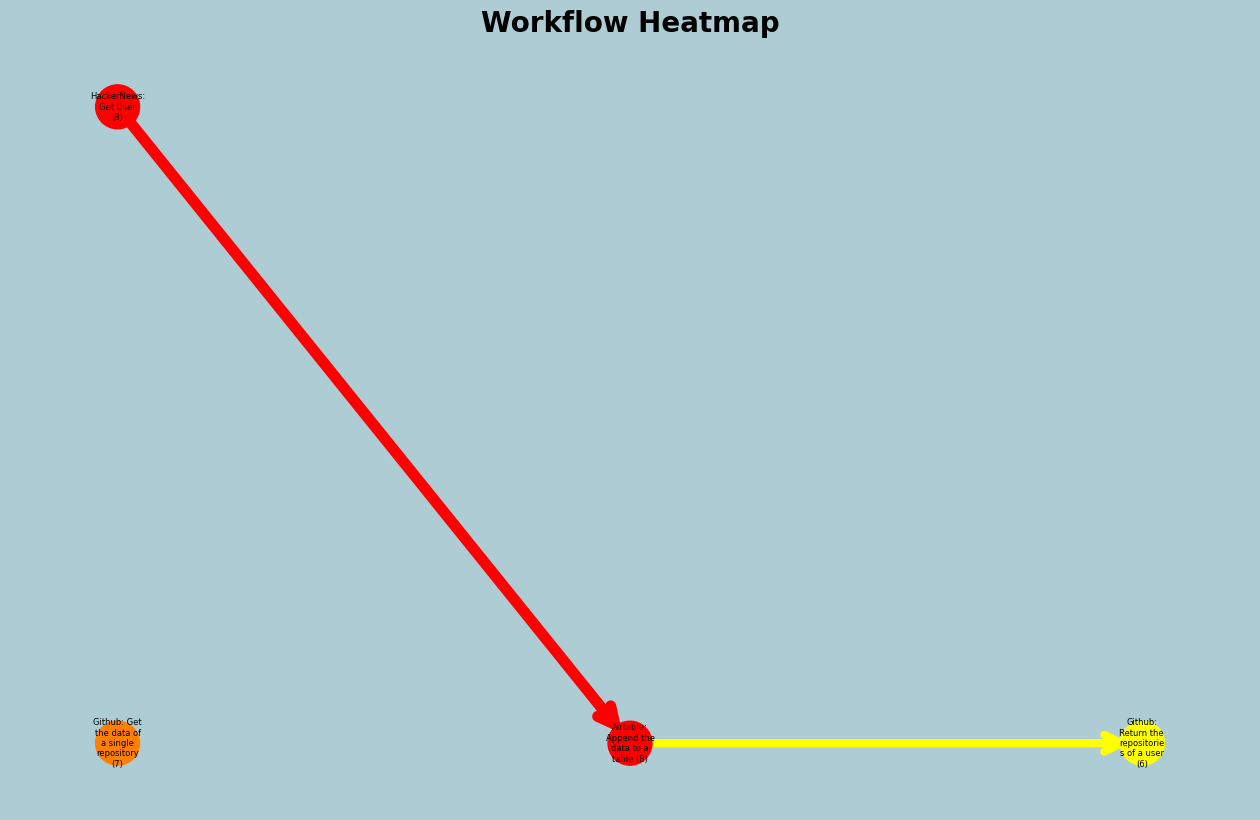

In [6]:
node_attributes = nx.get_node_attributes(G, "count")
edge_attributes = nx.get_edge_attributes(G, "frequency")
edge_weights = [edge_attributes[edge] for edge in G.edges()]
node_values = list(node_attributes.values())

cmap = plt.cm.get_cmap("autumn")
cmap = cmap.reversed()

vmin, vmax = min(node_values), max(node_values)
normalize = plt.Normalize(vmin=vmin, vmax=vmax)
node_colors = [cmap(normalize(value)) for value in node_values]
edge_colors = [cmap(normalize(session_tools[(tool1, tool2)])) for tool1, tool2 in G.edges()]
label_colors = ['white' if sum(c) / 3 < 0.7 else 'black' for c in node_colors]

fig, ax = plt.subplots(figsize=(16, 10))
node_size = 1000
label_font_size = 6

fig.set_facecolor("#aeccd4")

pos = draw_directed_graph(G.nodes(), G.edges())

nx.draw_networkx_edges(
    G,
    pos,
    width=edge_weights,
    edge_color=edge_colors,
    arrows=True,
    arrowstyle='->',
    arrowsize=30,
    connectionstyle="arc3,rad=0",
)

nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    node_shape='o',
    node_size=node_size,
    node_color=node_colors,
)

for node, color in zip(G.nodes(), label_colors):
    label_text = f'{node}\n({node_attributes[node]})'
    label = '\n'.join(textwrap.wrap(label_text, width=11))
    x, y = pos[node]
    ax.text(
        x, 
        y, 
        label, 
        fontsize=label_font_size, 
        verticalalignment='center',
        horizontalalignment='center',
    )

plt.title("Workflow Heatmap")
ax.title.set_size(20)
ax.title.set_fontweight("bold")
plt.axis("off")
plt.show()